# Graph Centrality

_UNDER CONSTRUCTION_


- Centrality: eigenvector, hub, authority, pagerank,
- BEA: Input-Output Use Table, e.g. Choi and Foerster (2017)


In [1]:
import time
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import networkx as nx
from finds.database import RedisDB
from finds.readers import Sectoring, BEA
from finds.graph import graph_info, nodes_centrality, graph_draw
from finds.misc import Show
from secret import credentials, paths
# %matplotlib qt
VERBOSE = 0
show = Show(ndigits=4, latex=None)

In [2]:
LAST_YEAR = 2021
years = np.arange(1947, LAST_YEAR) 
vintages = [1997, 1963, 1947]   # when sectoring schemes were revised
rdb = RedisDB(**credentials['redis'])
bea = BEA(rdb, **credentials['bea'], verbose=VERBOSE)
imgdir = paths['images'] / 'bea'

Read IOUse tables from BEA website

In [3]:
ioUses = dict()
for vintage in vintages:
    for year in [y for y in years if y >= vintage]:
        df = bea.read_ioUse(year, vintage=vintage)
        ioUses[(vintage, year)] = df
    print(f"{len(ioUses)} tables through sectoring vintage year {vintage}")

24 tables through sectoring vintage year 1997
82 tables through sectoring vintage year 1963
156 tables through sectoring vintage year 1947


In [4]:
## Set directed edges with tail on user (table column) --> head on maker (row)
## Direction of edges point from user industry to maker, i.e. follows the money
tail = 'colcode'   # edges follow flow of payments, from column to row
head = 'rowcode'   
drop = ('F','T','U','V','Other')  # drop these codes
colors = ['lightgrey', 'darkgreen', 'lightgreen']    
yearc = {}  # collect annual table

Populate and plot graph of first and last table years

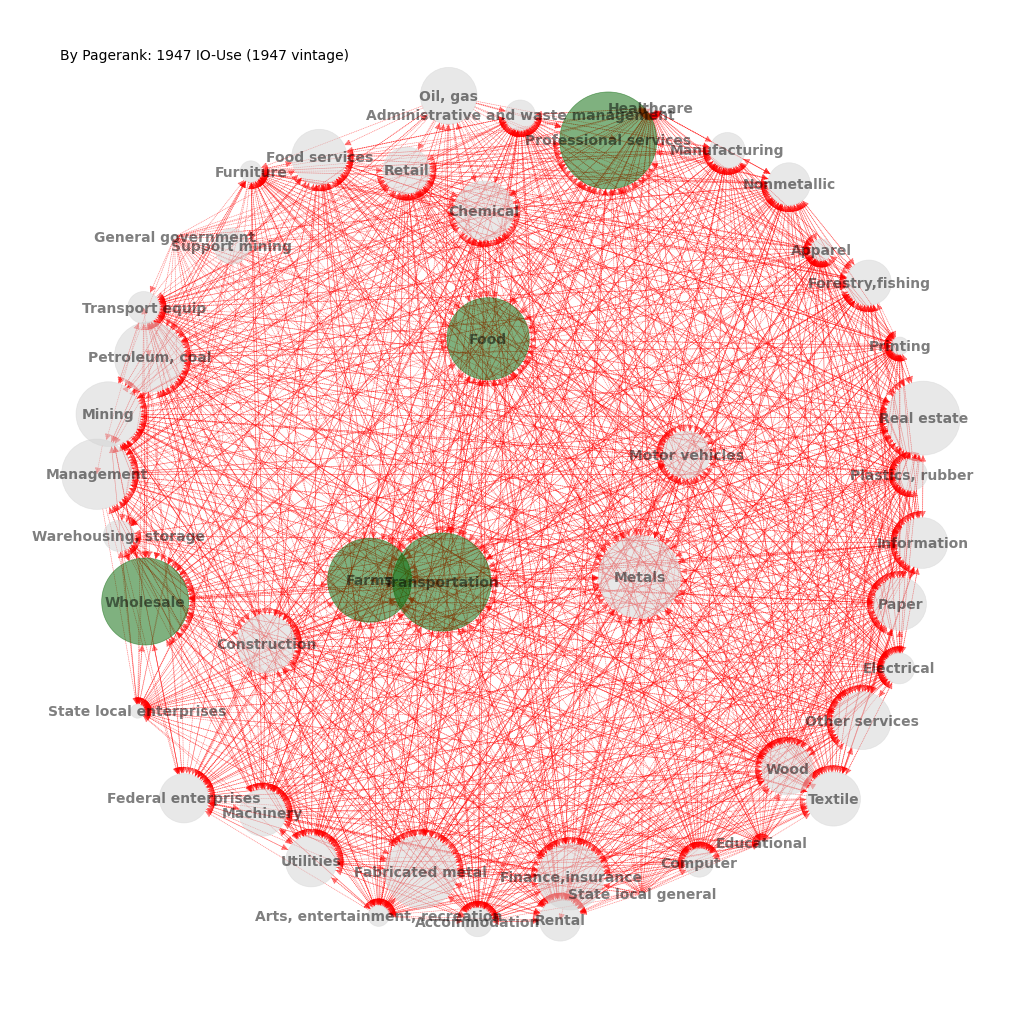

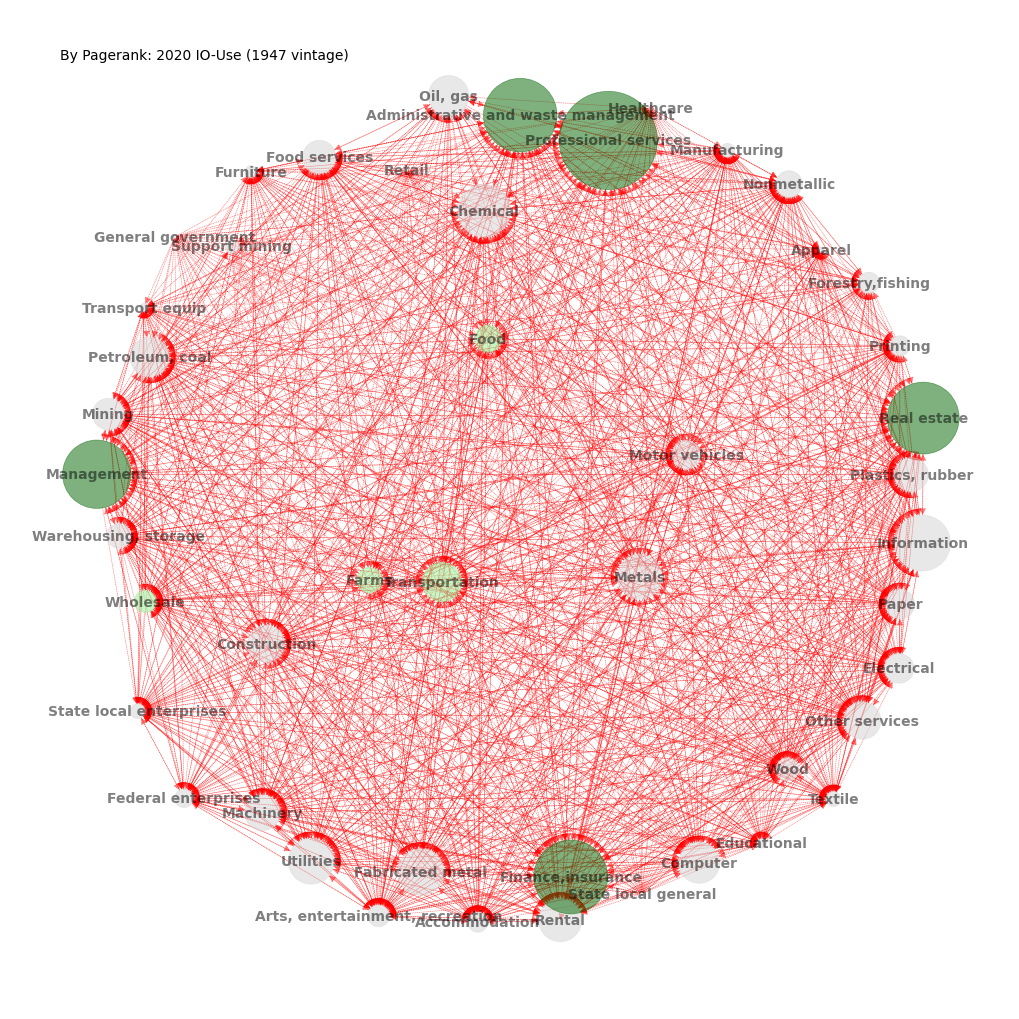

In [5]:
ifig, year = 0, 1947
vintage = 1947
year0 = 1947
#vintage = 1997
#year0 = 2019
year1 = 2020
for ifig, year in enumerate([year0, year1]):
    # keep year, drop invalid rows
    ioUse = ioUses[(vintage, year)]
    data = ioUse[(~ioUse['rowcode'].str.startswith(drop) &
                  ~ioUse['colcode'].str.startswith(drop))].copy()

    # create master table of industries and measurements
    master = data[data['rowcode']==data['colcode']][['rowcode','datavalue']]\
             .set_index('rowcode')\
             .rename(columns={'datavalue': 'self'})

    # extract cross data; generate and load edges (as tuples) to graph
    data = data[(data['colcode'] != data['rowcode'])]
    data['weights'] = data['datavalue'] / data['datavalue'].sum()
    edges = data.loc[data['weights'] > 0,
                     [tail, head, 'weights']].values.tolist()
    
    G = nx.DiGraph()
    G.add_weighted_edges_from(edges, weight='weight')
    nx_labels = BEA.bea_industry_[list(G.nodes)].to_dict()

    # update master table industry flow values
    master = master.join(data.groupby(['colcode'])['datavalue'].sum(),
                         how='outer').rename(columns={'datavalue': 'user'})
    master = master.join(data.groupby(['rowcode'])['datavalue'].sum(),
                         how='outer').rename(columns={'datavalue': 'maker'})
    master = master.fillna(0).astype(int)
    # inweight~supply~authority~eigenvector~pagerank, outweight~demand~hub

    centrality = DataFrame(nodes_centrality(G))
    master = master.join(centrality, how='left')
    master['bea'] = BEA.bea_industry_[master.index].to_list()
    yearc[year] = master[['pagerank', 'bea']].set_index('bea')

    # visualize graph
    score = centrality['pagerank']
    node_size = score.to_dict()
    node_color = {node: colors[0] for node in G.nodes()}
    if ifig == 0:
        center_name = score.index[score.argmax()]
    else:
        node_color.update({k: colors[2] for k in top_color})
    top_color = list(score.index[score.argsort()[-5:]])
    node_color.update(dict.fromkeys(top_color, colors[1]))
    pos = graph_draw(G,
                     num=ifig+1,
                     figsize=(10, 10),
                     center_name=center_name,
                     node_color=node_color,
                     node_size=node_size,
                     edge_color='r',
                     k=3,
                     pos=(pos if ifig else None),
                     font_size=10,
                     font_weight='semibold',
                     labels=master['bea'].to_dict(),
                     title=f"By Pagerank: {year} IO-Use ({vintage} vintage)")
    if imgdir:
        plt.savefig(imgdir / f"{year}.jpg")

In [6]:
## Display node centrality
c = pd.concat([yearc[year0].rank(ascending=False).astype(int),
               yearc[year1].rank(ascending=False).astype(int)],
              axis=1)
c.columns = pd.MultiIndex.from_product([[year0, year1], yearc[year0].columns])
c

,1947,2020
,pagerank,pagerank
bea,,
Farms,4,27
"Forestry,fishing",27,32
"Oil, gas",16,13
Mining,12,21
Support mining,31,38
Utilities,20,9
Construction,14,17
Food,5,25


In [7]:
## Display correlation of centrality ranks
c.corr().round(3)

,,1947,2020
,,pagerank,pagerank
1947,pagerank,1.00,0.62
2020,pagerank,0.62,1.00


In [8]:
# Display latest graph and node centrality
year = LAST_YEAR - 1
ioUse = ioUses[(1997, year)]
data = ioUse[(~ioUse['rowcode'].str.startswith(drop) &
              ~ioUse['colcode'].str.startswith(drop))].copy()

In [9]:
## extract cross data; generate and load edges (as tuples) to graph
data = data[(data['colcode'] != data['rowcode'])]
data['weights'] = data['datavalue'] / data['datavalue'].sum()
edges = data.loc[data['weights'] > 0, [tail, head, 'weights']].values.tolist()
G = nx.DiGraph()
G.add_weighted_edges_from(edges, weight='weight')

In [10]:
## update master table industry flow values and graph centrality measures
master = pd.concat((data[data['rowcode']
                         == data['colcode']][['rowcode','datavalue']]\
                    .set_index('rowcode')\
                    .rename(columns={'datavalue': 'self'}),
                    data.groupby(['colcode'])['datavalue'].sum()\
                    .rename('user'),
                    data.groupby(['rowcode'])['datavalue'].sum()\
                    .rename('maker')),
                   join='outer',
                   axis=1).fillna(0).astype(int)
master = master.join(DataFrame(nodes_centrality(G)), how='left')
master['bea'] = BEA.bea_industry_[master.index].to_list()
show(master.drop(columns=['self', 'clustering']),
     ndigits=3,
     caption=f"Centrality of BEA Input-Output Use Table {year}")

,user,maker,in_degree,out_degree,eigenvector,pagerank,hub,authority,betweenness,closeness,bea
Centrality of BEA Input-Output Use Table 2020,,,,,,,,,,,
111CA,194547,286362,0.4203,0.6232,0.0500,0.0088,0.0103,0.0133,0.0008,0.6330,Farms
113FF,5057,70809,0.3913,0.5362,0.0124,0.0061,0.0003,0.0020,0.0006,0.6216,"Forestry,fishing"
211,114812,262906,0.4203,0.5942,0.0809,0.0229,0.0064,0.0046,0.0161,0.6330,"Oil, gas"
212,34128,88125,0.7246,0.6522,0.0352,0.0139,0.0020,0.0050,0.0052,0.7841,Mining
213,27222,11272,0.0580,0.5942,0.0029,0.0027,0.0019,0.0002,0.0000,0.5149,Support mining
...,...,...,...,...,...,...,...,...,...,...,...
GFE,20912,61973,0.7826,0.6812,0.0155,0.0039,0.0015,0.0047,0.0065,0.8214,Federal enterprises
GFGD,276183,0,0.0000,0.6957,0.0000,0.0001,0.0181,-0.0000,0.0000,0.0000,Defense
GFGN,164988,0,0.0000,0.7826,0.0000,0.0001,0.0125,0.0000,0.0000,0.0000,Nondefense


In [11]:
Series(graph_info(G, fast=True))

weakly_connected                     True
weakly_connected_components             1
size_largest_weak_component            70
strongly_connected                  False
strongly_connected_components          10
size_largest_strong_component          61
directed                             True
weighted                             True
negatively_weighted                 False
edges                                3235
nodes                                  70
selfloops                               0
density                          0.669772
dtype: object